In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms


from torchinfo import summary

np.random.seed(0)
torch.manual_seed(0)

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [3]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.data_classes = self.image_folder
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        classes = self.data_classes.classes[label]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        varReturn = {
            "image": image,
            "label": label,
            "classes": classes,
            
        }
        
        
        
        return varReturn

In [4]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
    #  transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../../../dataset/SIBI/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/training/", transform=train_transform)

print(type(dataset))

<class '__main__.dawtaset'>


In [5]:
print(dataset[1000]['classes'])
print(dataset[1000]['label'])

G
6


In [6]:
from torch.utils.data import DataLoader, random_split
BATCH_SIZE = 32
# split dataset
# train_data, val_data = random_split(dataset, [0.80, 0.20])
data_val = dawtaset(image_path="../../../dataset/SIBI/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/validation/", transform=train_transform)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    


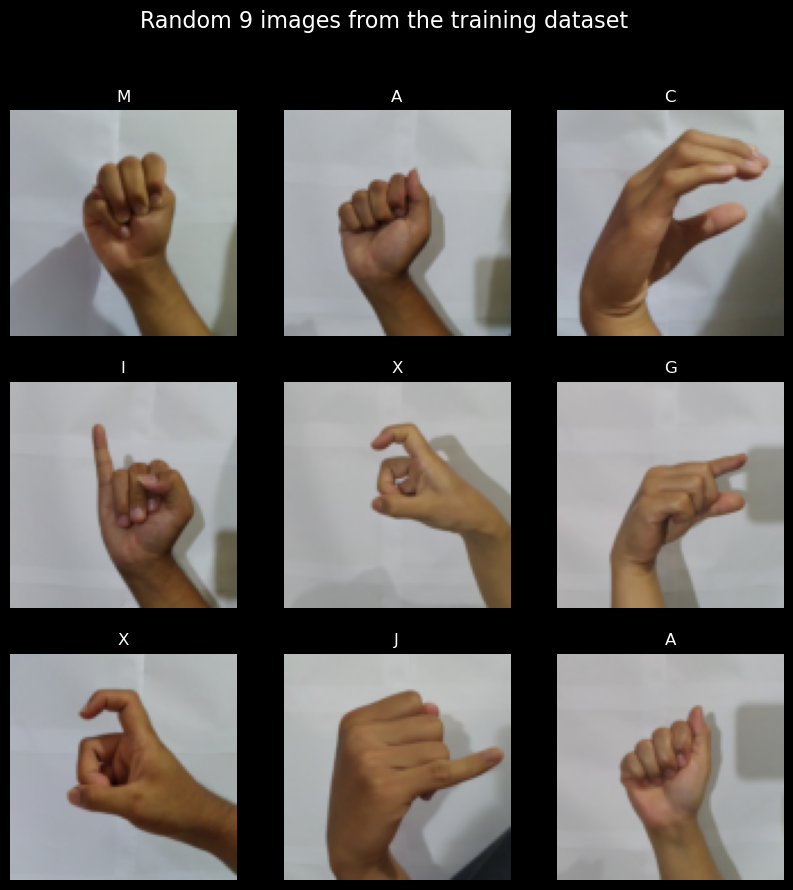

In [7]:
import matplotlib.pyplot as plt
import random

num_rows = 3
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(dataset))

        # Display the image in the subplot
        # print(training_dataset[image_index])
        axs[i, j].imshow(dataset[image_index]['image'].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(dataset[image_index]['classes'], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()

In [8]:
PATCH_SIZE = 10
IMAGE_WIDTH = 50
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 32
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

print(EMBEDDING_DIMS)

3200


In [9]:
# image embedding

conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

torch.Size([32, 3, 100, 100])


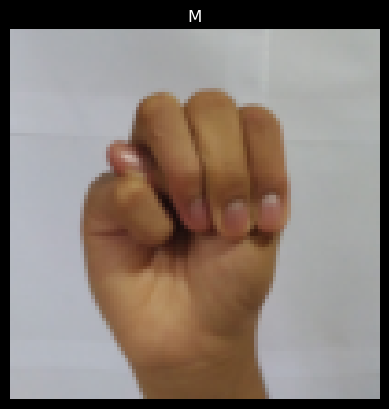

In [10]:
result = next(iter(train_dataloader))
random_image = result['image']
random_label = result['classes']
print(random_image.shape)


# Create a new figure
fig = plt.figure(1)

# Display the random image
plt.imshow(random_image[0].squeeze().permute(1,2,0))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(random_label[0], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")


In [11]:
# # image_through_conv = conv_layer(random_image)
# # print(image_through_conv.shape)
# image_through_conv = image_through_conv.permute((0, 2, 3, 1))
# print(image_through_conv.shape)

# flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
# image_through_conv_and_flatten = flatten_layer(image_through_conv)
# print(image_through_conv_and_flatten.shape)
# embedded_image = image_through_conv_and_flatten


In [12]:
import timm
resnet = timm.create_model('mobilenetv4_conv_small_050', pretrained=True, features_only=True)
conv_layer1 = nn.Conv2d(in_channels = 32, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

x1,x2,x3,x4,x5 = resnet(random_image)
print(x1.shape)

# image_through_conv = conv_layer(random_image)
image_through_conv_cnn = conv_layer1(x1)
# # print(image_through_conv.shape)

# # image_through_conv = image_through_conv.permute((0, 2, 3, 1))
image_through_conv_cnn = image_through_conv_cnn.permute((0, 2, 3, 1))
# print(image_through_conv_cnn.shape)

flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
image_through_conv_and_flatten = flatten_layer(image_through_conv_cnn)
print(image_through_conv_and_flatten.shape)
embedded_image = image_through_conv_and_flatten


Unexpected keys (classifier.bias, classifier.weight, conv_head.weight, norm_head.bias, norm_head.num_batches_tracked, norm_head.running_mean, norm_head.running_var, norm_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


torch.Size([32, 32, 50, 50])
torch.Size([32, 25, 3200])


In [13]:
import timm

BATCH_SIZE = 32
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=32, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        

        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        # print(self.class_token_embeddings.shape)
        # print(self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))).shape)
        # print(self.position_embeddings.shape)
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        # print(output.shape)
        return output

In [14]:

patch_embedding_layer = PatchEmbeddingLayer(in_channels=32, patch_size=PATCH_SIZE, embedding_dim=32 * PATCH_SIZE ** 2)

print(x1.shape)

patch_embeddings = patch_embedding_layer(x1)
# patch_embeddings.shape

torch.Size([32, 32, 50, 50])


In [15]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 32, IMAGE_WIDTH, IMAGE_HEIGHT), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [32, 32, 50, 50]     [32, 26, 3200]       185,600              True
├─Conv2d (conv_layer)                         [32, 32, 50, 50]     [32, 3200, 5, 5]     10,243,200           True
├─Flatten (flatten_layer)                     [32, 5, 5, 3200]     [32, 25, 3200]       --                   --
Total params: 10,428,800
Trainable params: 10,428,800
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.19
Input size (MB): 10.24
Forward/backward pass size (MB): 20.48
Params size (MB): 40.97
Estimated Total Size (MB): 71.69

In [16]:
# multihead attention
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims, # Hidden Size D in the ViT Paper Table 1
               num_heads,  # Heads in the ViT Paper Table 1
               attn_dropout # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [17]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 32,
                                                             attn_dropout= 0
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 26, 3200] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [32, 26, 3200] <= [batch_size, num_patches+1, embedding_dims ]


In [18]:
summary(model=multihead_self_attention_block,
        input_size=(1, 26, 3200), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 26, 3200]        [1, 26, 3200]        --                   True
├─LayerNorm (layernorm)                                      [1, 26, 3200]        [1, 26, 3200]        6,400                True
├─MultiheadAttention (multiheadattention)                    --                   [1, 26, 3200]        40,972,800           True
Total params: 40,979,200
Trainable params: 40,979,200
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.33
Forward/backward pass size (MB): 0.67
Params size (MB): 0.03
Estimated Total Size (MB): 1.02

In [19]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [20]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 3000,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 26, 3200), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 26, 3200]        [1, 26, 3200]        --                   True
├─LayerNorm (layernorm)                                           [1, 26, 3200]        [1, 26, 3200]        6,400                True
├─Sequential (mlp)                                                [1, 26, 3200]        [1, 26, 3200]        --                   True
│    └─Linear (0)                                                 [1, 26, 3200]        [1, 26, 3000]        9,603,000            True
│    └─GELU (1)                                                   [1, 26, 3000]        [1, 26, 3000]        --                   --
│    └─Dropout (2)                                                [1, 26, 3000]        [1, 26, 3000]        --                   --
│    └─Linear (3)                                            

In [21]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims,
               mlp_dropout,
               attn_dropout,
               mlp_size,
               num_heads,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [22]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 32)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 26, 3200] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [32, 26, 3200] <= [batch_size, num_patches+1, embedding_dims ]


In [23]:
summary(model=transformer_block,
        input_size=(1, 26, 3200), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 26, 3200]        [1, 26, 3200]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 26, 3200]        [1, 26, 3200]        --                   True
│    └─LayerNorm (layernorm)                       [1, 26, 3200]        [1, 26, 3200]        6,400                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 26, 3200]        40,972,800           True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 26, 3200]        [1, 26, 3200]        --                   True
│    └─LayerNorm (layernorm)                       [1, 26, 3200]        [1, 26, 3200]        6,400                True
│    └─Sequential (mlp)                            [1, 26, 3200]        [1, 26, 3200]        --                   True
│    │    └─Linear (0)                     

In [24]:
class ViT(nn.Module):
  def __init__(self, img_size,
               in_channels,
               patch_size,
               embedding_dims,
               num_transformer_layers, # from table 1 above
               mlp_dropout,
               attn_dropout,
               mlp_size,
               num_heads,
               num_classes):
    super().__init__()
    
    self.mobnet = timm.create_model('mobilenetv4_conv_small_050', pretrained=True, features_only=True)

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    x1,x2,x3,x4,x5 = self.mobnet(x)

    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x1))[:, 0])

In [25]:
vit = ViT(img_size = IMAGE_HEIGHT,
               in_channels = 32,
               patch_size = 10,
               embedding_dims = EMBEDDING_DIMS,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 32,
               num_classes = 26
          )

Unexpected keys (classifier.bias, classifier.weight, conv_head.weight, norm_head.bias, norm_head.num_batches_tracked, norm_head.running_mean, norm_head.running_var, norm_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [26]:
summary(model=vit,
        input_size=(BATCH_SIZE, 3, 100, 100), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 100, 100]    [32, 26]             --                   True
├─MobileNetV3Features (mobnet)                               [32, 3, 100, 100]    [32, 32, 50, 50]     --                   True
│    └─Conv2d (conv_stem)                                    [32, 3, 100, 100]    [32, 32, 50, 50]     864                  True
│    └─BatchNorm2d (bn1)                                     [32, 32, 50, 50]     [32, 32, 50, 50]     64                   True
│    └─ReLU (act1)                                           [32, 32, 50, 50]     [32, 32, 50, 50]     --                   --
│    └─Sequential (blocks)                                   --                   --                   --                   True
│    │    └─Sequential (0)                                   [32, 32, 50, 50]     [32, 16, 25,

In [27]:
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

running_loss_list = []
acc_list = []
num_correct = 0
num_samples = 0

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        image = inputs['image'].cuda()
        labels = inputs['label'].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(image)
        _, pred = outputs.max(1)
        
        # print("number correct", (pred == labels).sum())
        num_correct = (pred == labels).sum()
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print(loss)

        # print statistics
        running_loss += loss.item()
    print(running_loss/len(train_dataloader))
    running_loss_list.append(running_loss/len(train_dataloader))
    running_loss = 0.0
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0

print('Finished Training')

3.652124524116516
3.5529274582862853
3.449204836289088
3.0915285905202228
1.2006120830774307
0.14037602689350023
0.006147708148152257
0.0033010223569969336
0.0024174955857840055
0.0019783210950360323
0.00167509101787194
0.001401305962644983
0.001249762578906181
0.0011464832806571698
0.0010071528692302916
0.0009245262888725847
0.0008697761154811208
0.0008228757493877007
0.0007253440802742261
0.0007162649160212216
0.0006665685573049511
0.0006070155007667685
0.0005796688424500947
0.0005642405788724621
0.0005076096150636052
0.0004910699237370864
0.00047778674027843714
0.0004501318084900655
0.00043285004067001865
0.0004300273802073207
0.0004151755407898842
0.0003945911725168116
0.00037795092854745843
0.0003573894448588059
0.0003499248222700165
0.00035896206694208864
0.0003138446375184382
0.0003115466875897255
0.00030896830551985964
0.00029795004993502514
0.0003028704657481285
0.0002811682534229476
0.00027691290185127094
0.00026740725928296646
0.00026315993418393193
0.0002597485940592984
0.0

In [28]:
print(running_loss_list)

[3.652124524116516, 3.5529274582862853, 3.449204836289088, 3.0915285905202228, 1.2006120830774307, 0.14037602689350023, 0.006147708148152257, 0.0033010223569969336, 0.0024174955857840055, 0.0019783210950360323, 0.00167509101787194, 0.001401305962644983, 0.001249762578906181, 0.0011464832806571698, 0.0010071528692302916, 0.0009245262888725847, 0.0008697761154811208, 0.0008228757493877007, 0.0007253440802742261, 0.0007162649160212216, 0.0006665685573049511, 0.0006070155007667685, 0.0005796688424500947, 0.0005642405788724621, 0.0005076096150636052, 0.0004910699237370864, 0.00047778674027843714, 0.0004501318084900655, 0.00043285004067001865, 0.0004300273802073207, 0.0004151755407898842, 0.0003945911725168116, 0.00037795092854745843, 0.0003573894448588059, 0.0003499248222700165, 0.00035896206694208864, 0.0003138446375184382, 0.0003115466875897255, 0.00030896830551985964, 0.00029795004993502514, 0.0003028704657481285, 0.0002811682534229476, 0.00027691290185127094, 0.00026740725928296646, 0.0

In [29]:
import pandas as pd

rr = pd.DataFrame(running_loss_list, columns=['loss'])

<Axes: >

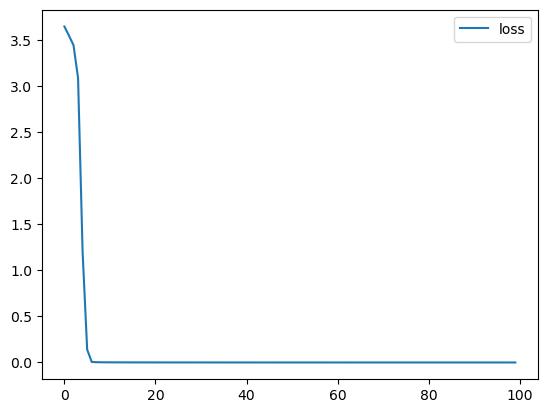

In [30]:
rr.plot()

In [31]:
# validation
val_loss_list = []
val_acc_list = []
with torch.no_grad():
    
    for i, data in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        image = inputs['image'].cuda()
        labels = inputs['label'].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(image)
        _, pred = outputs.max(1)
        
        # print("number correct", (pred == labels).sum())
        num_correct = (pred == labels).sum()
        totalData = data['label'].size(0)
        acc = num_correct/totalData
        print("acccccc", num_correct, totalData)
        val_acc_list.append(acc.item())
        
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()
        # print(loss)

        # print statistics
        running_loss += loss.item()
    print(running_loss/len(train_dataloader))
    val_loss_list.append(running_loss/len(train_dataloader))
    
    running_loss = 0.0

acccccc tensor(23, device='cuda:0') 32
acccccc tensor(27, device='cuda:0') 32
acccccc tensor(28, device='cuda:0') 32
acccccc tensor(22, device='cuda:0') 32
acccccc tensor(23, device='cuda:0') 32
acccccc tensor(26, device='cuda:0') 32
0.05998547424872716


In [32]:
val_acc_list = pd.DataFrame(val_acc_list, columns=['val_acc'])
val_acc_list.to_pickle('loss_asl_modif1')
print(val_acc_list.sum()/len(val_acc_list))

val_acc    0.776042
dtype: float64


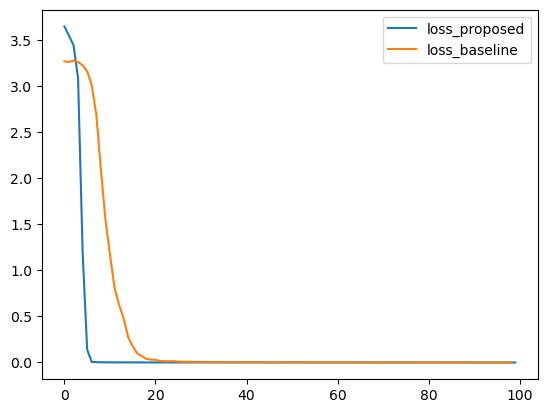

In [33]:
res_baseline = pd.read_pickle('sibi_loss_baseline')
plt.plot(rr, label='loss_proposed')
plt.plot(res_baseline, label='loss_baseline')
plt.legend()
plt.show()

In [34]:
torch.save(vit.state_dict(), "model_sibi_vit_modif")